## Data Collection and Feature Engineering steps

In [2]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer

# Download and load the train data
train_data_url = 'https://raw.githubusercontent.com/google-research/google-research/2adf640a14f11025ae5a9d0ec493b78530d276d3/goemotions/data/train.tsv'
train_data = pd.read_csv(train_data_url, sep='\t')

# Comment will be the only feature, emotion will be the target (multiple labels)
header = ["comment", "emotion", "id"]
train_data.columns = header

# Emotions dict
emotions_dict = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

# Remove instances with more than one emotion from each dataset
train_data = train_data[train_data['emotion'].apply(lambda x: len(x.split(',')) == 1)]

# Convert emotion column into integers
train_data['emotion'] = train_data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)

# Determine the frequency of each emotion
emotion_counts = train_data['emotion'].value_counts()

# Select the top 10 most common emotions
top_10_emotions = emotion_counts.head(10).index

# Filter the dataset to include only instances with the top 10 emotions
filtered_data = train_data[train_data['emotion'].isin(top_10_emotions)]

# Update the emotions_dict to include only the top 10 emotions
top_10_emotions_dict = {k: emotions_dict[k] for k in top_10_emotions}

# Tokenize the comments using the BERT tokenizer (Convert comments into Tokens)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_comments = tokenizer(filtered_data['comment'].to_list(), padding=True, truncation=True, return_tensors='pt')

# Convert tokenized data to numpy arrays
X_train = tokenized_comments['input_ids'].numpy()
attention_masks = tokenized_comments['attention_mask'].numpy()
y_train = filtered_data['emotion'].values

print("Top 10 most common emotions:", [top_10_emotions_dict[e] for e in top_10_emotions])
print("Filtered data shape:", filtered_data.shape)

Top 10 most common emotions: ['neutral', 'admiration', 'approval', 'gratitude', 'amusement', 'annoyance', 'love', 'disapproval', 'curiosity', 'anger']
Filtered data shape: (27608, 3)


# 1. Model Building - ML Classifiers

We try classic ML Classifiers first.

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

In [3]:
import os

# Disable parallelism in huggingface/tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for RandomizedSearchCV
param_dist = {'alpha': uniform(0.1, 5.0)}

# Initialize the Multinomial Naive Bayes classifier
multinomial_nb = MultinomialNB()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(multinomial_nb, param_distributions=param_dist, n_iter=3, cv=2, scoring='accuracy', verbose=4, n_jobs=-1)

# Train the classifier using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best estimator
best_classifier = random_search.best_estimator_

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END ..........alpha=1.0028986651655807;, score=0.088 total time=   0.2s
[CV 2/2] END ..........alpha=1.0028986651655807;, score=0.096 total time=   0.2s
[CV 2/2] END ..........alpha=3.3174477842811134;, score=0.096 total time=   0.2s
[CV 1/2] END ..........alpha=2.7969582745160086;, score=0.088 total time=   0.2s
[CV 1/2] END ..........alpha=3.3174477842811134;, score=0.088 total time=   0.2s
[CV 2/2] END ..........alpha=2.7969582745160086;, score=0.096 total time=   0.2s


In [4]:
# Get all score evaluations
cv_results = random_search.cv_results_

# Display the results
import pandas as pd

cv_results_df = pd.DataFrame(cv_results)
# Select relevant columns to display
columns_to_display = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = cv_results_df[columns_to_display]

print(cv_results_df.to_string(index=False))

                       params  mean_test_score  std_test_score  rank_test_score
{'alpha': 1.0028986651655807}         0.091749        0.003876                1
{'alpha': 3.3174477842811134}         0.091749        0.003876                1
{'alpha': 2.7969582745160086}         0.091749        0.003876                1


In [5]:
# alpha = 2.22
best_classifier

MultinomialNB(alpha=1.0028986651655807)

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed

def learning_curve(model, X, y, n_splits, train_sizes, verbose=False):
    train_scores = []
    val_scores = []

    train_scores_std = []
    val_scores_std = []

    def fit_and_score(train_index, test_index, X_subset, y_subset, model):
        X_fold, X_val_fold = X_subset[train_index], X_subset[test_index]
        y_fold, y_val_fold = y_subset[train_index], y_subset[test_index]

        model.fit(X_fold, y_fold)
        return model.score(X_fold, y_fold), model.score(X_val_fold, y_val_fold)

    for i, train_size in enumerate(train_sizes):
        X_subset = X[:int(train_size * len(X))]
        y_subset = y[:int(train_size * len(y))]
        
        cv = StratifiedKFold(n_splits=n_splits)
        
        if verbose:
            print(f"Processing train size {train_size * 100:.1f}% ({i + 1}/{len(train_sizes)})")
        
        results = Parallel(n_jobs=-1)(delayed(fit_and_score)(train_index, test_index, X_subset, y_subset, model)
                                      for train_index, test_index in cv.split(X_subset, y_subset))
        
        train_score, val_score = zip(*results)
        
        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))
        train_scores_std.append(np.std(train_score))
        val_scores_std.append(np.std(val_score))
        
        # if verbose:
        #     print(f"Train score: {train_scores[-1]:.4f} ± {train_scores_std[-1]:.4f}")
        #     print(f"Validation score: {val_scores[-1]:.4f} ± {val_scores_std[-1]:.4f}")

    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    train_scores_std = np.array(train_scores_std)
    val_scores_std = np.array(val_scores_std)
    
    return train_sizes, train_scores, val_scores, train_scores_std, val_scores_std


Processing train size 10.0% (1/10)
Processing train size 20.0% (2/10)
Processing train size 30.0% (3/10)
Processing train size 40.0% (4/10)
Processing train size 50.0% (5/10)
Processing train size 60.0% (6/10)
Processing train size 70.0% (7/10)
Processing train size 80.0% (8/10)
Processing train size 90.0% (9/10)
Processing train size 100.0% (10/10)


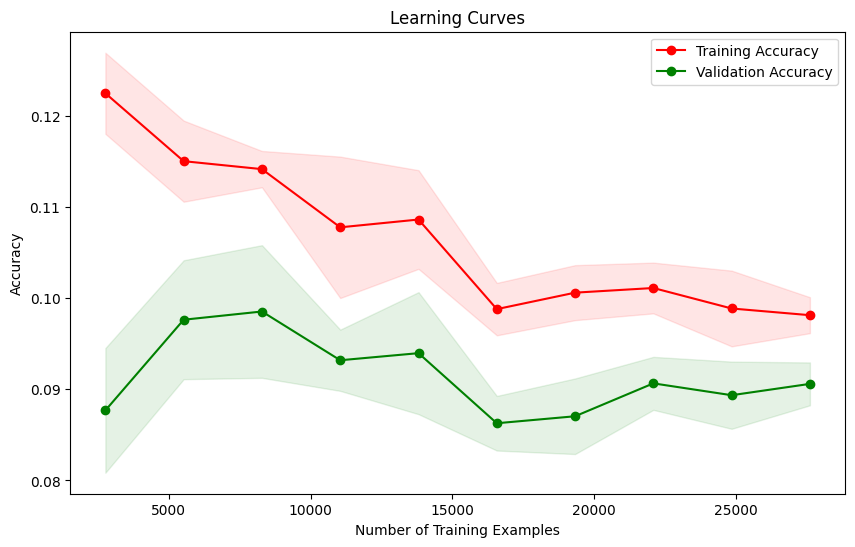

In [7]:
train_sizes, train_scores, val_scores, train_scores_std, val_scores_std = learning_curve(best_classifier,
                                                                                        X_train,
                                                                                        y_train,
                                                                                        n_splits=4,
                                                                                        train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes from 10% to 100%
                                                                                        verbose=True
                                                                                        )

# print("Training Scores:", train_scores)
# print("Validation Scores:", val_scores)

# Plotting the learning curves with standard deviations
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes * len(X_train), train_scores - train_scores_std,
                 train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes * len(X_train), val_scores - val_scores_std,
                 val_scores + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label='Training Accuracy')
plt.plot(train_sizes * len(X_train), val_scores, 'o-', color="g", label='Validation Accuracy')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [11]:
# Function to predict the emotion of a single comment
def predict_emotion(comment, model, tokenizer, emotions_dict):
    # Tokenize the comment
    tokenized_comment = tokenizer(comment, padding='max_length', truncation=True, max_length=X_train.shape[1], return_tensors='pt')
    # Convert tokenized data to numpy array
    X_comment = tokenized_comment['input_ids'].numpy()
    # Predict the emotion
    predicted_emotion_id = model.predict(X_comment)
    # Get the corresponding emotion label
    predicted_emotion = emotions_dict[predicted_emotion_id[0]]
    return predicted_emotion

# Example comment
example_comment = "i hate this"

# Predict the emotion of the example comment
predicted_emotion = predict_emotion(example_comment, best_classifier, tokenizer, emotions_dict)

print(f"The predicted emotion for the comment '{example_comment}' is: {predicted_emotion}")

The predicted emotion for the comment 'i hate this' is: admiration
